# Analysis of "Azerbaijani Laundromat" transaction data

## set up environment

Load the library dependencies

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta
import itertools
import json
import pathlib
import statistics
import typing

from icecream import ic
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyvis
import scipy
import seaborn as sns
import watermark

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-08-13T20:30:41.976989-07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.4.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas    : 2.3.0
json      : 2.0.9
networkx  : 3.5
scipy     : 1.16.0
matplotlib: 3.10.3
seaborn   : 0.13.2
pyvis     : 0.3.2
watermark : 2.5.0



Configure `pandas`

In [3]:
pd.set_option("display.max_rows", None)

## load the money transfer data

Load the OCCRP data for the "Azerbaijani Laundromat" leaked bank transactions <https://github.com/cj2001/senzing_occrp_mapping_demo/blob/main/occrp_17k.csv>

In [4]:
data_path: pathlib.Path = pathlib.Path("data")

In [5]:
occrp_file: pathlib.Path = data_path / "occrp_17k.csv"
df_orig: pd.DataFrame = pd.read_csv(occrp_file)

In [6]:
df_orig.head()

,payer_name,payer_jurisdiction,payer_account,source_file,amount_orig,id,beneficiary_type,beneficiary_core,amount_orig_currency,beneficiary_name,...,beneficiary_name_norm,payer_core,beneficiary_account,purpose,date,amount_usd,amount_eur,payer_type,payer_name_norm,payer_bank_country
0,AZARBAYCAN METANOL KOMPANI MMC,AZ,33817018409333311204,pdf/LCM ALLIANCE Account statement 30.06.12-31...,535470.00,6049,Company,True,USD,LCM ALLIANCE LLP,...,LCM ALLIANCE LLP,False,EE27 3300 3335 0561 0002,1206295100052180 OCT4121800021 ADVANCE PAYM FO...,2012-06-30,535470,"$431,762.31",Company,AZARBAYCAN METANOL KOMPANI MMC,33
1,LCM ALLIANCE LLP,GB,EE27 3300 3335 0561 0002,pdf/LCM ALLIANCE Account statement 30.06.12-31...,-535000.00,6050,Company,False,USD,MOBILA LLP,...,MOBILA LLP,True,333504500003,1207035026699176 INVOICE.No 6215 DD 25.05.2012,2012-07-03,535000,"$423,688.44",Company,LCM ALLIANCE LLP,EE
2,SKN ELECTRICAL SERVICES LIMITEDACCO,GB,20100374548222,pdf/METASTAR Account statement 30.06.12-31.12....,90535.19,10623,Company,True,USD,METASTAR INVEST LLP,...,METASTAR INVEST LLP,False,EE77 3300 3334 8704 0004,"1207065103089249 /FEE/USD4,81",2012-07-06,90536,"$71,698.53",Company,SKN ELECTRICAL SERVICES LIMITED,20
3,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-90520.00,15589,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207095022358525 DOGOVOR ZAYMA,2012-07-09,90520,"$71,686.50",Company,METASTAR INVEST LLP,EE
4,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-60.00,10624,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207135024578077 DOGOVOR ZAYMA,2012-07-13,60,$47.52,Company,METASTAR INVEST LLP,EE


In [7]:
df_orig.columns

Index(['payer_name', 'payer_jurisdiction', 'payer_account', 'source_file',
       'amount_orig', 'id', 'beneficiary_type', 'beneficiary_core',
       'amount_orig_currency', 'beneficiary_name', 'beneficiary_jurisdiction',
       'investigation', 'beneficiary_bank_country', 'beneficiary_name_norm',
       'payer_core', 'beneficiary_account', 'purpose', 'date', 'amount_usd',
       'amount_eur', 'payer_type', 'payer_name_norm', 'payer_bank_country'],
      dtype='object')

reduce the dataframe to just the slice needed for this analysis

In [8]:
cols_keep: typing.List[ str ] = [
    "date",
    "amount_orig",
    "payer_name",
    "beneficiary_name",
    "purpose",
    ]

diff: typing.Set[ str ] = set(df_orig.columns) - set(cols_keep)
    
df: pd.DataFrame = df_orig.drop(
    diff,
    axis = 1,
    inplace = False,
).sort_values(by = "date").reindex(columns = cols_keep)

df = df[df["amount_orig"] >= 0]
df.date = pd.to_datetime(df.date)

df.head()

,date,amount_orig,payer_name,beneficiary_name,purpose
0,2012-06-30,535470.00,AZARBAYCAN METANOL KOMPANI MMC,LCM ALLIANCE LLP,1206295100052180 OCT4121800021 ADVANCE PAYM FO...
2,2012-07-06,90535.19,SKN ELECTRICAL SERVICES LIMITEDACCO,METASTAR INVEST LLP,"1207065103089249 /FEE/USD4,81"
5,2012-07-13,189352.15,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,CONTRACT N 001 DD 24.12.2009
6,2012-07-13,225850.00,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,1207135026233261 CONTRACT N 001 DD 24.12.2009
21,2012-07-16,150000.00,MOBILA LLP,METASTAR INVEST LLP,1207165026198353 INVOICE.No 69 DD 13.07.2012


In [9]:
azeri_file: pathlib.Path = data_path / "azeri.csv"
df.to_csv(azeri_file, sep = "\t", encoding = "utf-8")

## descriptive statistics

In [10]:
df.describe(include = "all").loc[[ "count", "mean", "min", "max", "std", "freq", "unique", ]]

,date,amount_orig,payer_name,beneficiary_name,purpose
count,4069,4.069000e+03,4069,4069,4069
mean,2013-06-24 13:09:11.191939072,7.512028e+05,NaN,NaN,NaN
min,2012-06-30 00:00:00,6.600000e-01,NaN,NaN,NaN
max,2014-12-31 00:00:00,2.055997e+07,NaN,NaN,NaN
std,NaN,1.206048e+06,NaN,NaN,NaN
freq,NaN,NaN,530,1708,37
unique,NaN,NaN,437,4,3781


In [11]:
float(df["amount_orig"].sum()) / 10**9

3.05664418321

insights:

  * a total of \$3.06B in money transfers flowed through ~4K transactions
  * mean transfer amount is \$751K
  * max transfer amount is \$20.6M
  * funds drain into 4 companies

## graph construction

construct a graph in `NetworkX` for analysis, while also tallying the transaction flows, amounts, and inter-arrival times

In [12]:
graph: nx.DiGraph = nx.DiGraph()
node_names: list = []

edge_xact: dict = defaultdict(list)

for index, row in df.iterrows():
    src_label: str = row["payer_name"]
    dst_label: str = row["beneficiary_name"]

    if src_label not in node_names:
        node_names.append(src_label)
        src_id: int = node_names.index(src_label)

        graph.add_node(
            src_id,
            name = src_label,
        )            
    else:
        src_id = node_names.index(src_label)

    if dst_label not in node_names:
        node_names.append(dst_label)
        dst_id: int = node_names.index(dst_label)

        graph.add_node(
            dst_id,
            name = dst_label,
        )
    else:
        dst_id = node_names.index(dst_label)

    graph.add_edge(
        src_id,
        dst_id,
    )

    edge_xact[ (src_id, dst_id) ].append({
        "amount": row["amount_orig"],
        "date": datetime.fromisoformat(str(row["date"])),
    })    

In [13]:
for node_id, degree in sorted(nx.degree(graph), key = lambda x: x[1], reverse = True):
    graph.nodes[node_id]["degree"] = degree

## inter-arrival modeling

describe the distributions of transaction inter-arrival times (days in-between) and amounts

In [14]:
summary_data: list = []
timing_data: list = []

for edge, dat in edge_xact.items():        
    dates: list = sorted([
        xact["date"]
        for xact in dat
    ], reverse = False)

    inter_arrival: list = [
        (pair[1] - pair[0]).days
        for pair in itertools.pairwise(dates)
    ]

    timing_data.extend(inter_arrival)

    amounts: list = [
        xact["amount"]
        for xact in dat
    ]

    summary_data.append({
        "src_id": edge[0],
        "dst_id": edge[1],
        "median_amount": statistics.median(amounts),
        "total_amount": sum(amounts),
    })

df_summary: pd.DataFrame = pd.DataFrame.from_dict(
    summary_data,
    orient = "columns"
)

df_summary.head()

,src_id,dst_id,median_amount,total_amount
0,0,1,109510.00,1511916.50
1,2,3,10101.00,110063.19
2,4,3,189352.15,415231.08
3,5,3,300000.00,4729714.00
4,6,3,50000.00,12747647.00


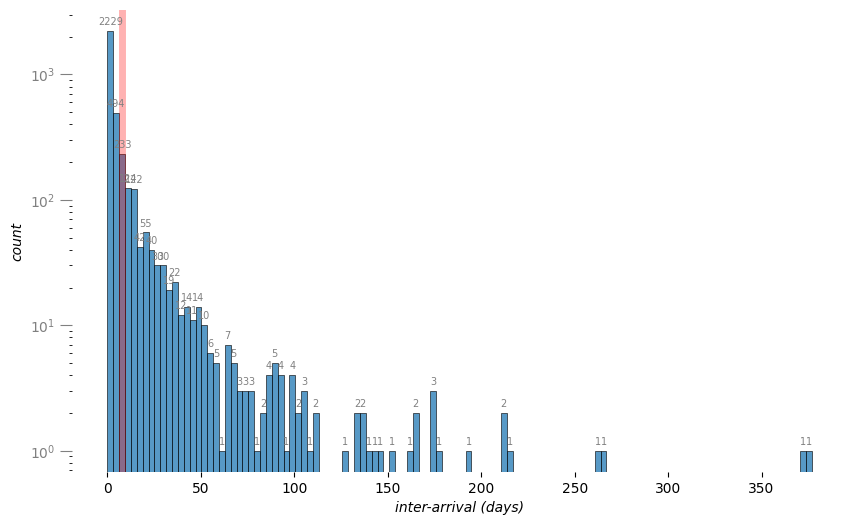

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(timing_data)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("inter-arrival (days)", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)

plt.axvline(x = statistics.mean(timing_data), color = "red", lw = 5, alpha = 0.3)
plt.yscale("log")

plt.legend([], [], frameon = False);

In [16]:
max(timing_data)

377

In [17]:
min(timing_data)

0

In [18]:
statistics.mean(timing_data)

7.678282687482576

In [19]:
statistics.median(timing_data)

2

In [20]:
statistics.stdev(timing_data)

20.509698291006327

In [21]:
df_summary.describe()

,src_id,dst_id,median_amount,total_amount
count,482.000000,482.000000,4.820000e+02,4.820000e+02
mean,208.769710,50.107884,4.667940e+05,6.341585e+06
std,129.118082,110.394929,1.286354e+06,5.817122e+07
min,0.000000,1.000000,6.600000e-01,6.600000e-01
25%,95.250000,1.000000,4.634000e+04,6.790158e+04
50%,205.000000,1.000000,1.641615e+05,4.745085e+05
75%,320.750000,3.000000,4.880025e+05,2.010612e+06
max,436.000000,302.000000,2.055997e+07,1.239991e+09


insights:

  * mean total transfer between two nodes is \$6.34M
  * max total transfer is \$1.24B
  * mean of the median transfer amount between two nodes is \$46.7K

  * exponential distribution for inter-arrival times (days)
	* min 0
	* median 2
	* mean 7.68
	* max 377
	* stdev 20.51

## general ledger

apply basic accounting practices to model the in-flows, out-flows, and resulting balances

In [22]:
for node_id in graph.nodes():
    graph.nodes[node_id]["count"] = 0
    graph.nodes[node_id]["volume"] = 0
    graph.nodes[node_id]["credits"] = 0
    graph.nodes[node_id]["debits"] = 0

for index, row in df_summary.iterrows():
    src_id: int = row["src_id"]
    dst_id: int = row["dst_id"]
    amount: float = float(row["total_amount"])

    graph.nodes[src_id]["count"] += 1
    graph.nodes[src_id]["volume"] += amount
    graph.nodes[src_id]["debits"] += amount

    graph.nodes[dst_id]["count"] += 1
    graph.nodes[dst_id]["volume"] += amount
    graph.nodes[dst_id]["credits"] += amount

for node_id in graph.nodes():
    graph.nodes[node_id]["balance"] = round(graph.nodes[node_id]["credits"] - graph.nodes[node_id]["debits"], 2)

In [23]:
nodes_dat: typing.List[ dict ] = [
    dat
    for _, dat in graph.nodes(data = True)
]

df_nodes: pd.DataFrame = pd.DataFrame.from_dict(
    nodes_dat,
    orient = "columns"
)

df_nodes.head()

,name,degree,count,volume,credits,debits,balance
0,AZARBAYCAN METANOL KOMPANI MMC,1,1,1.511916e+06,0.000000e+00,1511916.50,-1.511916e+06
1,LCM ALLIANCE LLP,273,273,8.648721e+08,8.564284e+08,8443707.00,8.479847e+08
2,SKN ELECTRICAL SERVICES LIMITEDACCO,1,1,1.100632e+05,0.000000e+00,110063.19,-1.100632e+05
3,METASTAR INVEST LLP,134,134,4.296297e+08,3.557691e+08,73860598.00,2.819085e+08
4,INMAXO CAPITAL CORP.,1,1,4.152311e+05,0.000000e+00,415231.08,-4.152311e+05


In [24]:
df_nodes.describe()

,degree,count,volume,credits,debits,balance
count,437.000000,437.000000,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02
mean,2.205950,2.205950,1.398922e+07,6.994609e+06,6.994609e+06,1.363951e-10
std,14.766024,14.766024,1.139791e+08,8.597658e+07,7.043787e+07,1.082390e+08
min,1.000000,1.000000,6.600000e-01,0.000000e+00,6.600000e-01,-1.452793e+09
25%,1.000000,1.000000,6.242700e+04,0.000000e+00,6.242700e+04,-1.720020e+06
50%,1.000000,1.000000,4.608160e+05,0.000000e+00,4.608160e+05,-4.012300e+05
75%,1.000000,1.000000,1.948477e+06,0.000000e+00,1.948477e+06,-5.490000e+04
max,273.000000,273.000000,1.586775e+09,1.506709e+09,1.452793e+09,1.426642e+09


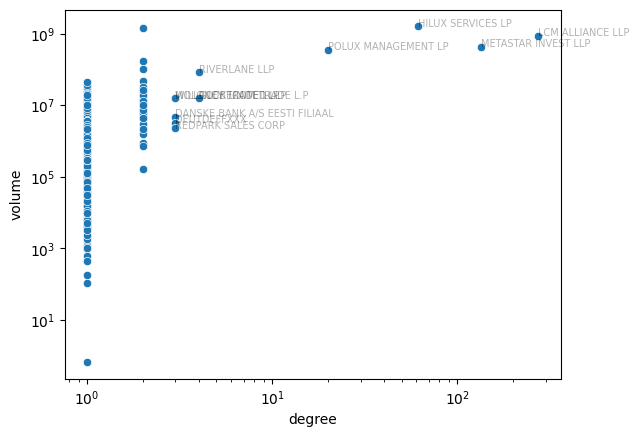

In [25]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["volume"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "degree", y = "volume")

plt.yscale("log")
plt.xscale("log")

for i, label in enumerate(labels):
    if x[i] > 2: # only label the top-ranked 14 companies
        plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

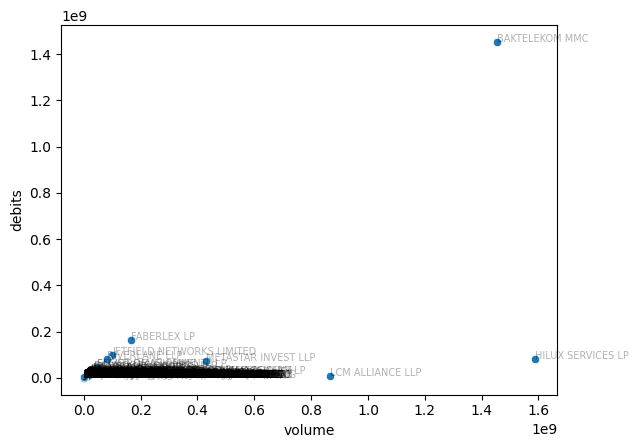

In [26]:
x: list = df_nodes["volume"].to_list()
y: list = df_nodes["debits"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "volume", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

this chart illustrates the "sources" (negative balance, below center) and "drains" (positive balance, above center)

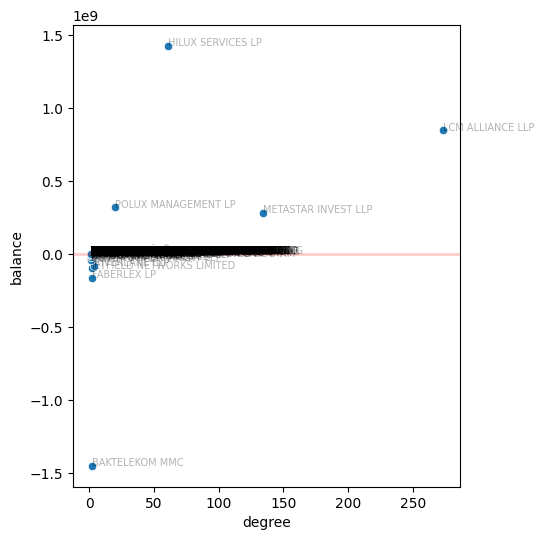

In [27]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["balance"].to_list()
labels: list = df_nodes["name"].to_list()

fig, ax = plt.subplots(figsize = (5, 6))
plt.rcParams["font.family"] = "sans-serif"

sns.scatterplot(data = df_nodes, x = "degree", y = "balance")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.axhline(y = 0, color = "red", lw = 2, alpha = 0.2)

plt.show()

insights:

  * mean credits/debits through a given node is \$7M
  * mean count of transfers through a given node is 2.2
  * funds appear to have sourced through many shell companies, with "BAKTELEKOM MMC" being the largest
  * funds appear to have drained from "LCM", "HILUX", "POLUX", and "METASTAR"

## centrality measure

calculate _betweenness centrality_ measures for each node

In [28]:
ranks: dict = nx.betweenness_centrality(
    graph,
    weight = "volume",
    normalized = True,
    endpoints = True,
)

for node_id, rank in sorted(ranks.items(), key = lambda x: x[1], reverse = True):
    graph.nodes[node_id]["rank"] = round(rank, 4)

    if rank > 0.0001:
        print(f"{node_id:3} rank {rank:.4}",  graph.nodes[node_id]["name"])

  1 rank 0.003894 LCM ALLIANCE LLP
  3 rank 0.002837 METASTAR INVEST LLP
302 rank 0.001128 HILUX SERVICES LP
298 rank 0.001068 POLUX MANAGEMENT LP


## simple graph analytics

now we have some descriptive stats to use for modeling a simulation of these kinds of transactions; let's look into other potential parameters for simulation, based on graph analytics

In [29]:
nx.diameter(graph.to_undirected())

4

In [30]:
nx.density(graph)

0.0025297587806772616

In [31]:
nx.girth(graph.to_undirected())

1

In [32]:
node_degree: typing.List[ int ] = dict(nx.degree(graph)).values()
max(node_degree)

273

let's look in detail at the relatively higher degree nodes

In [33]:
for node_id, degree in sorted(nx.degree(graph), key = lambda x: x[1], reverse = True):
    if degree >= 3:
        print(f"{node_id:3} {degree:3}", graph.nodes[node_id])

  1 273 {'name': 'LCM ALLIANCE LLP', 'degree': 273, 'count': 273, 'volume': 864872099.2599998, 'credits': 856428392.2599998, 'debits': 8443707.0, 'balance': 847984685.26, 'rank': 0.0039}
  3 134 {'name': 'METASTAR INVEST LLP', 'degree': 134, 'count': 134, 'volume': 429629674.48999995, 'credits': 355769076.48999995, 'debits': 73860598.0, 'balance': 281908478.49, 'rank': 0.0028}
302  61 {'name': 'HILUX SERVICES LP', 'degree': 61, 'count': 61, 'volume': 1586775234.5099998, 'credits': 1506708859.3299997, 'debits': 80066375.18, 'balance': 1426642484.15, 'rank': 0.0011}
298  20 {'name': 'POLUX MANAGEMENT LP', 'degree': 20, 'count': 20, 'volume': 356302899.13, 'credits': 337737855.13, 'debits': 18565044.0, 'balance': 319172811.13, 'rank': 0.0011}
 17   4 {'name': 'GLOBECOM TRADE L.P', 'degree': 4, 'count': 4, 'volume': 15608252.0, 'credits': 0, 'debits': 15608252.0, 'balance': -15608252.0, 'rank': 0.0}
 66   4 {'name': 'RIVERLANE LLP', 'degree': 4, 'count': 4, 'volume': 82016410.99000001, 'cr

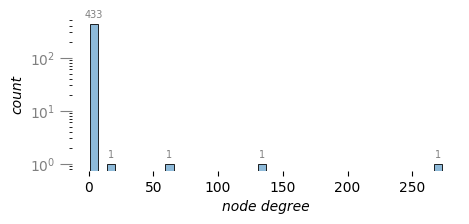

In [34]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(node_degree)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("node degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

insights:

  * a sparse directed graph with cycles
  * not wide, `diameter = 4`
  * power law distribution on node degree

## components and paths

In [35]:
for clique in nx.connected_components(graph.to_undirected()):
    print(clique)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [36]:
len(list(nx.strongly_connected_components(graph)))

435

In [37]:
strong_edges: list = []

for clique in nx.strongly_connected_components(graph):
    if len(clique) > 1:
        strong_edges.append(sorted(list(clique)))
        print("\n", clique)

        for node_id in clique:
            dat: dict = graph.nodes[node_id]
            print(f"{node_id:3}", dat["name"])


 {1, 3}
  1 LCM ALLIANCE LLP
  3 METASTAR INVEST LLP

 {298, 302}
298 POLUX MANAGEMENT LP
302 HILUX SERVICES LP


In [38]:
path_counts: typing.List[ int ] = [
    len(path[1]) + 1
    for path in nx.all_pairs_all_shortest_paths(graph)
]

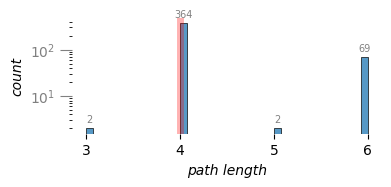

In [39]:
fig, ax = plt.subplots(figsize = (4, 1.5))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(path_counts)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("path length", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

plt.axvline(x = statistics.median(path_counts), color = "red", lw = 5, alpha = 0.3)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
y.set(xticks = range(min(path_counts), max(path_counts) + 1))

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

insights:

  * fully connected graph, `avg path length = 4`
  * 2 strongly connected components, among pairs of the "drain" shell companies

## flow analysis

In [40]:
nx.flow_hierarchy(graph)

0.9896265560165975

since most of the nodes are on the periphery, what's happening in-between them?

In [41]:
for node_id in nx.center(graph.to_undirected()):
    print(node_id, graph.nodes[node_id])

17 {'name': 'GLOBECOM TRADE L.P', 'degree': 4, 'count': 4, 'volume': 15608252.0, 'credits': 0, 'debits': 15608252.0, 'balance': -15608252.0, 'rank': 0.0}
66 {'name': 'RIVERLANE LLP', 'degree': 4, 'count': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99, 'rank': 0.0}


In [42]:
neg_bal: int = 0  # sources
pos_bal: int = 0  # drains
zed_bal: int = 0  # conduits

for node_id in nx.periphery(graph.to_undirected()):
    dat: dict = graph.nodes[node_id]

    if dat["balance"] < 0:
        neg_bal += 1
    elif dat["balance"] > 0:
        pos_bal += 1
    else:
        zed_bal += 1

ic(neg_bal, pos_bal, zed_bal);

ic| neg_bal: 423, pos_bal: 0, zed_bal: 0


In [43]:
len(graph.nodes)

437

In [44]:
len(list(nx.periphery(graph.to_undirected())))

423

In [45]:
non_periph: set = set(graph.nodes) - set(nx.periphery(graph.to_undirected()))

details: dict = {
    node_id: graph.nodes[node_id]
    for node_id in non_periph
}

for node_id, dat in sorted(details.items(), key = lambda pair: pair[1]["rank"], reverse = True):
    print(f"{node_id:3}", dat)

  1 {'name': 'LCM ALLIANCE LLP', 'degree': 273, 'count': 273, 'volume': 864872099.2599998, 'credits': 856428392.2599998, 'debits': 8443707.0, 'balance': 847984685.26, 'rank': 0.0039}
  3 {'name': 'METASTAR INVEST LLP', 'degree': 134, 'count': 134, 'volume': 429629674.48999995, 'credits': 355769076.48999995, 'debits': 73860598.0, 'balance': 281908478.49, 'rank': 0.0028}
298 {'name': 'POLUX MANAGEMENT LP', 'degree': 20, 'count': 20, 'volume': 356302899.13, 'credits': 337737855.13, 'debits': 18565044.0, 'balance': 319172811.13, 'rank': 0.0011}
302 {'name': 'HILUX SERVICES LP', 'degree': 61, 'count': 61, 'volume': 1586775234.5099998, 'credits': 1506708859.3299997, 'debits': 80066375.18, 'balance': 1426642484.15, 'rank': 0.0011}
 66 {'name': 'RIVERLANE LLP', 'degree': 4, 'count': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99, 'rank': 0.0}
  7 {'name': 'DANSKE BANK A/S EESTI FILIAAL', 'degree': 3, 'count': 3, 'volume': 4800552.32, 'credits

let's keep track of these intermediary nodes in particular, which don't rank as high in centrality -- what is flowing through them?

In [46]:
intermed: typing.Set[ int ] = non_periph - set([ 1, 302, 298, 3, ])

insights:

  * nodes in the periphery are "sources" (negative balance) and none are "drains" (end with a positive balance)

  * 10 intermediary nodes don't rank as high in centrality as the 4 "drain" shell companies mentioned in the investigative journalism articles
     * these 10 are in the computed "center" of the graph
     * what patterns of transactions flow through these?

## directed flows

In [47]:
for node_id in graph.nodes():
    deg: int = graph.in_degree(node_id)

    if deg > 0:
        dat = graph.nodes[node_id]
        print(f"{deg:3} in degree {node_id:3}", dat["name"])

272 in degree   1 LCM ALLIANCE LLP
132 in degree   3 METASTAR INVEST LLP
 18 in degree 298 POLUX MANAGEMENT LP
 60 in degree 302 HILUX SERVICES LP


In [48]:
for node_id in graph.nodes():
    deg: int = graph.out_degree(node_id)
    graph.nodes[node_id]["out_deg"] = deg

label the "role" for each node

In [49]:
for node_id in graph.nodes():
    if graph.in_degree(node_id) > 0:
        graph.nodes[node_id]["role"] = "drain"
    elif graph.out_degree(node_id) > 1:
        graph.nodes[node_id]["role"] = "multi-source"
    elif graph.nodes[node_id]["balance"] < 0:
        graph.nodes[node_id]["role"] = "source"

In [50]:
flows_dat: list = [
    {
        "node_id": node_id,
        "name": dat["name"],
        "role": dat["role"],
        "out_deg": dat["out_deg"],
        "balance": dat["balance"],
        "count": dat["count"],
        "volume": dat["volume"],
        "credits": dat["credits"],
        "debits": dat["debits"],        
    }
    for node_id, dat in graph.nodes(data = True)
    if dat["out_deg"] > 0
]

df_flows: pd.DataFrame = pd.DataFrame.from_dict(
    flows_dat,
    orient = "columns"
)

df_flows.head()

,node_id,name,role,out_deg,balance,count,volume,credits,debits
0,0,AZARBAYCAN METANOL KOMPANI MMC,source,1,-1.511916e+06,1,1.511916e+06,0.000000e+00,1511916.50
1,1,LCM ALLIANCE LLP,drain,1,8.479847e+08,273,8.648721e+08,8.564284e+08,8443707.00
2,2,SKN ELECTRICAL SERVICES LIMITEDACCO,source,1,-1.100632e+05,1,1.100632e+05,0.000000e+00,110063.19
3,3,METASTAR INVEST LLP,drain,2,2.819085e+08,134,4.296297e+08,3.557691e+08,73860598.00
4,4,INMAXO CAPITAL CORP.,source,1,-4.152311e+05,1,4.152311e+05,0.000000e+00,415231.08


In [51]:
df_flows.describe(include = "all").loc[[ "count", "mean", "min", "max", "std", "freq", "unique", ]]

,node_id,name,role,out_deg,balance,count,volume,credits,debits
count,437.000000,437,437,437.000000,4.370000e+02,437.000000,4.370000e+02,4.370000e+02,4.370000e+02
mean,218.000000,NaN,NaN,1.102975,1.363951e-10,2.205950,1.398922e+07,6.994609e+06,6.994609e+06
min,0.000000,NaN,NaN,1.000000,-1.452793e+09,1.000000,6.600000e-01,0.000000e+00,6.600000e-01
max,436.000000,NaN,NaN,4.000000,1.426642e+09,273.000000,1.586775e+09,1.506709e+09,1.452793e+09
std,126.295289,NaN,NaN,0.378208,1.082390e+08,14.766024,1.139791e+08,8.597658e+07,7.043787e+07
freq,NaN,1,399,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,437,3,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_flows.groupby(["role"]).count()["node_id"]

role
drain             4
multi-source     34
source          399
Name: node_id, dtype: int64

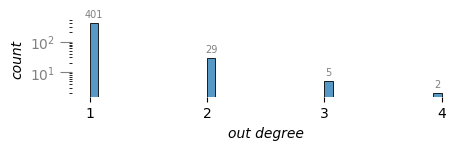

In [53]:
dat = df_flows["out_deg"].to_list()

fig, ax = plt.subplots(figsize = (5, 1))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(dat)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("out degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
y.set(xticks = range(min(dat), max(dat) + 1))

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

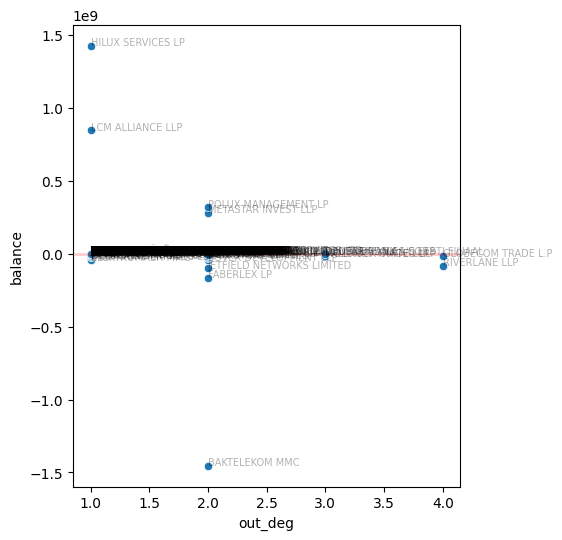

In [54]:
x: list = df_flows["out_deg"].to_list()
y: list = df_flows["balance"].to_list()
labels: list = df_flows["name"].to_list()

fig, ax = plt.subplots(figsize = (5, 6))
plt.rcParams["font.family"] = "sans-serif"

sns.scatterplot(data = df_flows, x = "out_deg", y = "balance")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.axhline(y = 0, color = "red", lw = 2, alpha = 0.2)

plt.show()

here are the shell companies which had more funds transferred out than transferred in

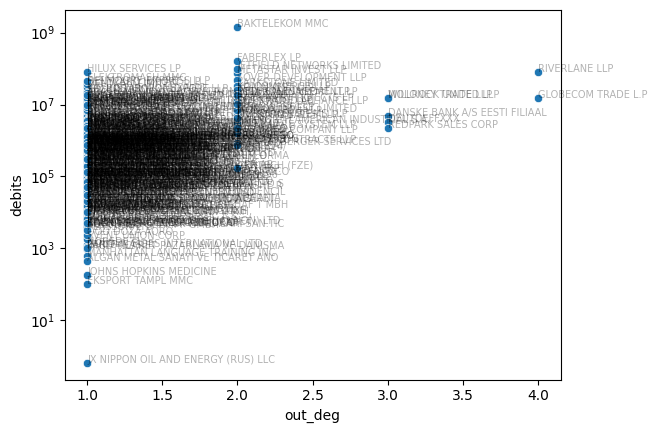

In [55]:
x: list = df_flows["out_deg"].to_list()
y: list = df_flows["debits"].to_list()
labels: list = df_flows["name"].to_list()

sns.scatterplot(data = df_flows, x = "out_deg", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.yscale("log")
plt.show()

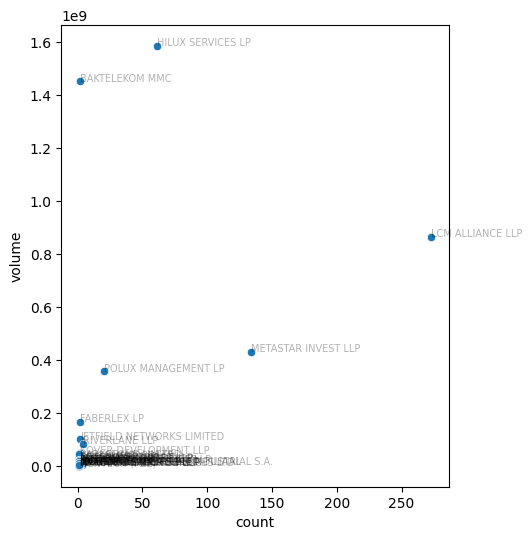

In [56]:
x: list = df_flows["count"].to_list()
y: list = df_flows["volume"].to_list()
labels: list = df_flows["name"].to_list()

fig, ax = plt.subplots(figsize = (5, 6))
plt.rcParams["font.family"] = "sans-serif"

sns.scatterplot(data = df_flows, x = "count", y = "volume")

for i, label in enumerate(labels):
    if x[i] > 1:
        plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

One lingering question: how much much was "shuffled" between the four "drain" shell companies, ostensibly in an effort to hide their operations?

In [57]:
end_balance: float = float(df_flows.loc[df_flows["role"] == "drain"]["balance"].sum())
ic(end_balance);

total_credits: float = float(df_flows.loc[df_flows["role"] == "drain"]["credits"].sum())
ic(total_credits);

total_debits: float = float(df_flows.loc[df_flows["role"] == "drain"]["debits"].sum())
ic(total_debits);

ic(round(total_debits / total_credits, 3));

ic| end_balance: 2875708459.03
ic| total_credits: 3056644183.209999
ic| total_debits: 180935724.18
ic| round(total_debits / total_credits, 3): 0.059


insights:

  * role "source" = 399
  * role "multi-source" = 34
  * role "drain" = 4
  * the "drain" companies shuffled $181M (5.9%) between each other, ostensibly to conceal operations?

## serialize results

In [58]:
occrp_file: pathlib.Path = data_path / "occrp.json"

with open(occrp_file, "w") as fp:  # pylint: disable=W1514                                                                                                    
    dat: dict = nx.node_link_data(
        graph,
        link = "edges", # for forward compatibility                                                                                                          
    )

    json.dump(
        dat,
        fp,
        indent = 2,
        ensure_ascii = False,
    )

/var/folders/8f/wmjh62kx07vfnc2h3rsbclq80000gn/T/ipykernel_54389/1540771529.py:4: DeprecationWarning: Keyword argument 'link' is deprecated; use 'edges' instead
  dat: dict = nx.node_link_data(


## triadic census

In [59]:
for triad, occurrences in sorted(nx.triadic_census(graph).items(), key = lambda x: x[1], reverse = True):
    if occurrences > 0:
        print(f"triad {triad:>5}: {occurrences:7d} occurrences")

triad   003: 13652536 occurrences
triad   012:  113313 occurrences
triad  021U:   46815 occurrences
triad   102:     425 occurrences
triad  111D:     411 occurrences
triad  120D:      33 occurrences
triad  021D:      19 occurrences
triad  021C:      15 occurrences
triad  030T:       2 occurrences
triad  111U:       1 occurrences


<img
 src="https://figures.semanticscholar.org/6ebe86cdf25f3b58dd98dd9c1c00c3f5c2491734/2-Figure1-1.png"
 style="height:500px"
/>

insights:

  * the many `021U` triads indicate "burst in beneficiaries" AML tradecraft pattern?

## network visualization

In [60]:
role_colors: dict = {
    "source": "#BDC561",
    "multi-source": "#D9CAD7",
    "drain": "#C25FB8",
}

role_shapes: dict = {
    "source": "square",
    "multi-source": "diamond",
    "drain": "circle",
}

In [61]:
def render_graph (
    graph: nx.DiGraph,
    ) -> pyvis.network.Network:
    """
    Generate a `PyVis` network visualization from the DiGraph
    """
    net: pyvis.network.Network = pyvis.network.Network(
        notebook = True,
        cdn_resources = "in_line",
        directed = True,
        height = "900px", 
        width = "100%",
    )
    
    # adjust node attributes
    net.from_nx(graph)

    for node in net.nodes:
        node["value"] = node["volume"]
        node["label"] = node["name"]

        node["color"] = role_colors[node["role"]]
        node["shape"] = role_shapes[node["role"]]

        if node["name"] == "BAKTELEKOM MMC":
            node["color"] = "#3381EA"

        title: str = node["name"] + "\nnode_id: " + str(node["id"])

        for key in [ "role", "rank", "count" ]:
            title += f"\n{key}: " + str(node[key])

        for key in [ "volume", "balance", "credits", "debits", ]:
            title += f"\n{key}: {node[key]:.3e}"
        
        node["title"] = title
    
    # adjust edge attributes
    for edge in net.edges:
        arc: list = sorted([ edge["from"], edge["to"] ])

        if arc in strong_edges:
            edge["width"] = 10

    return net

construct a graph `PyVis` for visualization

In [62]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.toggle_physics(True)

net.prep_notebook()
net.show_buttons(filter_ = [ "physics" ])

options: str =     """
  "physics": {
    "forceAtlas2Based": {
      "centralGravity": 0.04,
      "springLength": 5,
      "springConstant": 0.32,
      "avoidOverlap": 0.02
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
    """

#net.set_options(options)
# setting options via Py interface doesn't work?

net.show("occrp.html")

occrp.html


Note: to see the final graph, load the HTML file `occrp.html` in your browser.

## summary

#### graph shape:

  * this is a sparse directed graph with cycles
  * it's not wide, `diameter = 4`
  * power law distribution for node degree
  * fully connected graph, `avg path length = 4`
  * there are 2 strongly connected components, among pairs of the "drain" shell companies
  * the many `021U` triads indicate a "burst in beneficiaries" AML tradecraft pattern
  * 423 nodes in the periphery are "sources" (negative balance) and none are "drains" (end with a positive balance)

#### money transfers:

  * a total of \$3.06B in money transfers flowed through ~4K transactions
  * mean transfer amount is \$751K
  * max transfer amount is \$20.6M
  * mean total transfer between two nodes is \$6.34M
  * max total transfer is \$1.24B
  * mean of the median transfer amount between two nodes is \$46.7K
  * mean credits/debits through a given node is \$7M
  * mean count of transfers through a given node is 2.2

  * exponential distribution for inter-arrival times (days)
	* min 0
	* median 2
	* mean 7.68
	* max 377
	* stdev 20.51

#### shell companies:

  * roles of the shell companies:
	* "source" 399
	* "multi-source" 34 (transfers to 2+ other companies)
	* "drain" 4

 * the "drain" companies shuffled $181M (5.9%) between each other, ostensibly to conceal operations?

#### strategy:

  * "BAKTELEKOM MMC", the local bank, was the largest "source"
  * funds were sourced through 432 other shell companies
  * funds drained into 4 companies: "LCM ALLIANCE LLP", "METASTAR INVEST LLP", "POLUX MANAGEMENT LP", "HILUX SERVICES LP"

OCCRP analysis and the subsequent investigative journalism articles mention these 4 top shell companies involved in the "Azerbaijani Laundromat"

There are 10 shell companies which are sources of funds for multiple drains:

  * "DANSKE BANK A/S EESTI FILIAAL"
  * "RIVERLANE LLP"
  * "GLOBECOM TRADE L.P"
  * "MOLONEY TRADE LLP"
  * "DEUTDEFFXXX"
  * "WILLROCK UNITED LLP"
  * "HARDWARE SYSTEM LLP"
  * "BONDWEST LLP"
  * "DELFRONT IMPORT LLP"
  * "REDPARK SALES CORP"

Leaked transaction data came from an Estonian branch of Danske Bank, which is one of these multi-source nodes: "DANSKE BANK A/S EESTI FILIAAL" https://thebanks.eu/banks/13002